# __Text classification : Predicting a pop song's genre from its lyrics__


## __Contents__

<font color='brown'>I. Introduction</font>

<font color='blue'>1. Domain specific area</font>

<font color='blue'>2. Objectives</font>

<font color='blue'>3. Dataset</font>

<font color='blue'>4. Evaluation methodology</font>

<font color='brown'>II. Implementation</font>

<font color='blue'>1. Set up packages</font>

<font color='blue'>2. User defined functions</font>

<font color='blue'>3. Import data</font>

<font color='blue'>4. Review of the data</font>

<font color='blue'>5. Data preprocessing</font>
  
     a Cleaning
     b Split into training and test datasets
     c Vectorization of 'Lyrics' text feature
     d Metric scaling
     e Rebalancing
<font color='blue'>6. Classifiers</font>
  
     a Multinomial Naive Bayes model
     b Random forest
     c Linear Support Vector Machine
     d fastText
<font color='brown'>III. Conclusions</font>

<font color='blue'>1. Performance</font>

     a Overall accuracy
     b Accuracy by genre
     c Precision and recall by genre
     d ROC curves (one vs the rest) for selected solution
<font color='blue'>2. Summary</font>
  
<font color='brown'>IV. References</font>

<font color='brown'>V. Requirements file</font>

## <font color='brown'>I. Introduction</font>

### <font color='blue'>1. Domain specific area</font>

Genres and sub-genres of popular music indicate that there is a degree of similarity in the songs assigned to them. Currently Spotify does not use lyrics in their algorithms for determining a song's genre (Boonyanit et al, 2021). Instead it considers audio type metrics such as 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo' and 'duration_ms' derived from meta data.

As genre and sub-genre play a key part in content-based filtering recommendation engines it is important that songs are categorised as best as possible. As it's easy to deduce that for some genres its lyrical content can differ significantly, e.g. country music versus rap or heavy metal, this project aims to see if lyrics alone can be an effective classifier of songs.

If so, lyrics could be a consideration for inclusion to current recommendation algorithms.

### <font color='blue'>2. Objectives</font>

1. Test if the lyics of a song alone are a good predictor of its genre

  - If a model can be built which shows reasonable statistical power above a set baseline then the work could provide input into other genre tagging projects which do not use lyrics
  - Lyrics may provide some uplift in existing models which in turn may lead to improved performance for recommendation systems using genre

2. Summarise possible setbacks and potential areas of improvement with the approaches undertaken

### <font color='blue'>3. Dataset</font>

The dataset to be used is from Kaggle page 'Audio features and lyrics of Spotify songs' (Nakhaee, M) and comprises 18.5K songs and 25 features. Each row of data comprises the data of one song. It was sourced from Spotify for its audio-type features using the Spotify API and used genius library in R to source and add the lyrics and their respective language.

The features include:
- audio type metrics mentioned above which are all numeric values
- text identifers of each song - song ID, song name, artist name, album ID, album name and language
- lyrics - which is simply one long string for each song
- genre - the label feature. There are six different genres available for each song - Rock, Pop, R&B, Rap, EDM and Latin - with only one label assigned per song

Some non-English lyrics are present as well as punctuation. So all of the usual NLP preprocessing steps will be required before modelling.

A key challenge could be finding the best algorithm/embedding which can handle semantics of rare/made-up words which appear in lyrics e.g. 'litty litty', 'brudda', 'dem', most notably for the urban genres of Rap and R&B. Lemmatization itself could be a challenge for a lot of tokens.

### <font color='blue'>4. Evaluation methodology</font>

While there are some excellent papers available on this topic it is difficult to use their findings as a comparable baseline for evaluation purposes. Often the data sources they point to are no longer available or there are differences in the types of classification objective (multi-label genre vs multi-class genre) or the number of genres studied and their definitions differ across the datasets used by researchers.

Given this absence two baselines will be considered, firstly the prior probabilities of the genre labels themselves can be used to determine a rule for basic classification assignment. Second, a quick and dirty model using multinomial Naive Bayes can be built on the most basic vectorization of the lyric text data (term frequency). The final model is expected to shows statistical power over this NB model.

The final model will be developed after considering the results of several types of text vectorizations and classifier types. Evaluation will be conducted using the appropriate Python package to compute the statistics of accuracy, recall, precision and f1 score - both at the genre-level and aggregate-level for each model. Ideally a high f1 score which minimizes false positives and false negatives is preferred. Accuracy by itself can be misleading if the data is imbalanced significantly.

## <font color='brown'>II. Implementation</font>

### <font color='blue'>1. Set up packages</font>

These cells must be run. A requirements file has been provided to help reconcile any compatibility issues

In [ ]:
#!pip install wordcloud
#!pip install imblearn
#!pip install gensim

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import itertools

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import re
import string
translator=str.maketrans(string.punctuation,' '*len(string.punctuation)) # Map any punctuation characters to white space
import nltk
from nltk.data import find
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim.utils import simple_preprocess
import fasttext

from sklearn.preprocessing import LabelBinarizer, MaxAbsScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, RocCurveDisplay, confusion_matrix
from imblearn.over_sampling import RandomOverSampler,SMOTEN

### <font color='blue'>2. User defined functions</font>
This cell comprises the collection of functions written to achieve most of the heavy lifting in the required data processing that follows. This cell needs to be run before any of the subsequent cells

In [ ]:
def insight_plot(data,x,y,orient,xlabel,ylabel,title,pos1,pos2,plot_type):
    '''
    This function takes as input:
    - dataframe comprising the x and y series to be plotted
    - orientation option ('h' or 'v')
    - the x and y axis labels for plot presentation
    - position coordinates in subplot() output grid
    - type of chart to be created ('bar','stem_leaf')
    '''
    if plot_type=='bar':
        ax=sns.barplot(data=data,x=x,y=y,color='steelblue',ax=axes[pos1][pos2],ci=None)
    elif plot_type=='stem_leaf':
        ax=sns.boxplot(data=data, x=x, y=y,color='steelblue',orient=orient,ax=axes[pos1][pos2],showfliers=False)
    ax.set(xlabel=xlabel)
    ax.set(ylabel=ylabel)
    ax.set_title(label=title,loc='left')
    return

def reformat(text):
    '''
    This function takes as input a list and outputs it as one element list
    '''
    text1=[]
    text1.append(' '.join(text))
    text2=str(text1)
    return text2

def cleaning1(data,stop_words):

    '''
    This function takes as input:
    - dataframe comprising the lyrics for each song and the genre labels
    - stopwords to be excluded from analysis
    The output is a dataframe with cleaned version of 'lyrics' and 'playlist_genre' ready for vectorization
    '''

    # Keep only lyrics and genre for English songs
    data1=data.loc[data['language']=='en'][['lyrics','playlist_genre']]

    # Drop duplicate songs
    data1.drop_duplicates(subset=["lyrics", "playlist_genre"], keep=False,inplace=True)
    data1=data1.reset_index().drop(['index'],axis=1)

    # Drop songs with no lyrics
    data1=data1.loc[((data1['lyrics'].isna())==False)]

    # Convert labels into integer values
    genre_mapping={'pop':0,'rock':1,'r&b':2,'rap':3,'edm':4,'latin':5}
    data1['playlist_genre_int']=data1['playlist_genre'].map(genre_mapping)

    ##### Convert text feature 'lyrics' into cleaned tokens #####

    # Convert to lower case
    data1['lyrics']=data1['lyrics'].apply(lambda x: x.lower())

    # Remove punctuation
    data1['lyrics']=data1['lyrics'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

    # Just keep words and spaces
    data1['lyrics']=data1['lyrics'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    data1['lyrics']=data1['lyrics'].apply(lambda x: re.sub(r'\d', '', x))

    # Remove foreign language characters
    data1['lyrics']=data1['lyrics'].apply(lambda x: re.sub(r'[^\x00-\x7f]', "", x))

    # Tokenize
    data1['lyrics']=data1['lyrics'].apply(lambda x: word_tokenize(x))

    # Remove stopwords (need to be transformed as per other words)
    stop_words1=[x.translate(str.maketrans('', '', string.punctuation)) for x in stop_words]
    data1['lyrics']=data1['lyrics'].apply(lambda x: [word for word in x if word not in (stop_words)])

    # Lemmatization using part-of-speech verb tagging
    data1['lyrics']=data1['lyrics'].apply(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x]) # lemmatize(word,pos="v")

    # Convert 'lyrics' into a list of just one element ready for vectorization
    data1['lyrics']=data1['lyrics'].apply(lambda x: reformat((x)))

    return data1, stop_words1, genre_mapping

def word_freqs(data,playlist_genre_int,stop_words):
    '''
    This function takes as input:
    - dataframe comprising the lyrics for every song
    - genre identifier for genre of interest
    - stopwords to be excluded from analysis
    It oytputs for each genre a wordcloud object and a frequency count dataframe for top 20 words
    '''
    # Pull together all words in each genre
    words=" ".join(songs1[songs1['playlist_genre_int']==playlist_genre_int]['lyrics'].values)

    # Create wordcloud object
    wordcloud=WordCloud(stopwords=stop_words,
                        background_color='white',
                        collocations = False,
                        max_words=1000).generate(words)

    # Get list of top 20 words by frequency
    words1=words.split()
    words2=[w for w in words1 if w not in (stop_words)]
    f=nltk.FreqDist(words2)
    f_sort=dict(sorted(f.items(),key=lambda x:x[1],reverse=True))
    top_20=dict(itertools.islice(f_sort.items(), 20))
    top_20_df=pd.DataFrame(top_20.items(),columns=[str(playlist_genre_int),'freq']).drop('freq',axis=1)

    return wordcloud, top_20_df

def plot_wordcloud(data,num_genres,stop_words,genre_mapping,title1,title2):

    '''
    This function takes as input:
    - dataframe comrpising the lyrics for every song
    - count of genres to be analysed
    - list of stopwords to be excluded from analysis
    - map of genre codes to genre names
    - chart and table heading text
    For each genre it outputs a wordcloud chart and a frequency count table for top 20 words
    '''

    fig=plt.figure(figsize=(10,10),dpi=1000)
    fig.tight_layout()
    fig.subplots_adjust(top=0.98)

    all=pd.DataFrame()

    for i in range(num_genres):
        ax=fig.add_subplot(3,2,i+1)
        ax.imshow(word_freqs(data,i,stop_words)[0])
        ax.axis('off')
        ax=fig.subplots_adjust(wspace=0.01,hspace=0.0001)
        fig.suptitle(title1,fontsize=7)
        # Get genre name for sub-titles
        genre=[k for k, v in genre_mapping.items() if v==(i)][0]
        plt.title(genre.upper(),size=7)

        # Get top 20 words per genre
        top_20_df=word_freqs(data,i,stop_words)[1]
        top_20_df.rename(columns={str(i):genre},inplace=True)
        all=pd.concat([all,top_20_df],axis=1)

    plt.show()

    print(title2)
    print(all)

    return

def cleaning2(data):
    '''
    Function to split dataset row strings into tokens & remove selected characters
    Outputs cleaned dataset
    '''
    # Need to split cleaned lyrics above into tokens
    data1=data.copy()
    data2=data1.apply(lambda x: x.split(' '))

    # Remove the rogue characters at beginning and end of the song's lyrics
    # Consider each row (song)
    for i in range(data2.shape[0]):
        # Consider each word in a row (song)
        for j in range(len(data2.iloc[i])):
            # Replace rogue characters
            data2.iloc[i][j]=data2.iloc[i][j].replace("['",'').replace("']",'')

    # Get list of tokenized_sentences (song lyrics)
    tokenised_sentences=[]
    # Consider each row (song)
    for i in range(data2.shape[0]):
        # Add list of words to all_sentences
        tokenised_sentences.append(data2.iloc[i])

    return tokenised_sentences

def acc(model,X_train,y_train,X_test,y_test,title):
    '''
    Inputs: model type already instantiated, training data, test data and title for printout
    '''
    model1=model.fit(X_train,y_train.values.ravel())
    pred=model1.predict(X_test)
    print("{:0.2f}".format(round(accuracy_score(y_test,pred),2)),'-',title)
    return pred,y_test,title

# Clean 'pred'
def find_genre(string):
    '''
    Input is a string
    Function seeks a match with one of 6 set music genres in string
    Output is one music genre
    '''
    result=''
    for s in string:
        if re.search('rock', s):
            result='rock'
        elif re.search('r&b', s):
            result='r&b'
        elif re.search('rap', s):
            result='rap'
        elif re.search('pop', s):
            result='pop'
        elif re.search('edm', s):
            result='edm'
        elif re.search('latin', s):
            result='latin'
        else:
            result='none'
        return result

def conf(y_test,y_pred,chart_num,chart_title):
    '''
    Input is the actual and predicted genre classifications and chart title details
    Output is a classification matrix
    '''
    cm=confusion_matrix(y_test,y_pred)
    cm1=np.true_divide(cm,cm.sum(axis=1,keepdims=True))
    subjects=['edm','latin','pop','r&b','rap','rock']
    colormap=sns.color_palette("Blues",12)
    fig,ax=plt.subplots(figsize=(10,6))
    ax=sns.heatmap(cm1, linewidth=0.5, annot=True, annot_kws={"size": 13}, fmt='0.0%', xticklabels=subjects, yticklabels=subjects,cmap=colormap)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 13)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 13)
    ax.set_title('Figure '+str(chart_num)+': '+chart_title,fontsize=14,loc='left')
    plt.yticks(rotation=0)
    plt.show()
    return

def report(y_test,y_pred,table_num,table_title):
    '''
    Inputs are the actual and predicted genre classifications and the chart title information
    Output is a table comprising the precision and recall statistics for each genre and aggregate statistics
    '''
    target_names = ['edm','latin','pop','r&b','rap','rock']
    print('Table '+str(table_num)+': '+table_title)
    print('')
    print(classification_report(y_test,y_pred,target_names=target_names))
    print('')
    print('')
    return

def auc_plot(genre,title):
    '''
    This function takes as input a song genre and then outputs its ROC curve for on vs rest
    '''

    class_of_interest=genre
    class_id = np.flatnonzero(label_binarizer.classes_==class_of_interest)[0]

    RocCurveDisplay.from_predictions(y_onehot_test[:, class_id],
                                     y_score[:, class_id],
                                     name=f"{class_of_interest} vs the rest",
                                     color="darkorange")

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC curves: "+title+" vs rest")
    plt.legend()
    plt.show()

    return

### <font color='blue'>3. Import data</font>
- Dataset comprises 18,454 songs and 25 features
- Asides 'lyrics', the other text features identify the artist, album and playlist types for which a song is assigned
- Numeric features identify attributes of each song in terms of sound such as: 'tempo', 'loudness' or 'danceability'

In [ ]:
songs=pd.read_csv('spotify_songs.csv')
print(songs.shape)
print(songs.dtypes)

(18454, 25)
track_id                     object
track_name                   object
track_artist                 object
lyrics                       object
track_popularity              int64
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
language                     object
dtype: object


### <font color='blue'>4. Review of the data</font>
A quick review of the data using the code below shows that:
1. The data is nearly fully populated with only 260 songs not having observations for the 'lyrics' and 'language' features
2. The data comprises a significant number of rows with duplicate 'lyrics' due to songs being collected from different albums e.g. remasters or greatest hits collections. See Table 1 for an example. Duplicates  will need to be removed so that there is no risk of the same song appearing in both the training and test datasets. The number of songs reduces to 15,260
3. The majority (83%) of song lyrics are written in English (Figure 1)
4. The dataset is inbalanced in terms of the playlist genres not being equally represented (Figure 2) so rebalancing will be required ahead of model building to avoid particular genres dominating classifications of unseen songs
5. In terms of contribution to the size of the corpus, the 'Rap' genre contributes songs with the highest median number of words (including stop words) while the 'EDM' and 'Rock' genres contribute the lowest (Figure 3)

#### a. Check for missing values

In [ ]:
for i in songs.columns:
    if songs[i].isna().sum()!=0:
        print(str(i),songs[i].isna().sum())

lyrics 260
language 260


#### b. Check for redundancy

#### _Count of number of duplicate songs_

In [ ]:
songs[["lyrics", "playlist_genre"]].duplicated(keep=False).sum()

3194

#### _Get example of a duplicated song_

In [ ]:
feats=songs[['lyrics','playlist_genre']]
dups=feats[feats.duplicated(keep=False)].sort_values(by='lyrics')
example1=dups.head(2).index.values.astype(int)[0]
example2=dups.head(2).index.values.astype(int)[1]

# Get the feature data for each duplicates
songs_sel=songs.drop(['lyrics'],axis=1)
example1a=songs_sel.iloc[example1,0:]
example2a=songs_sel.iloc[example2,0:]
both=pd.concat([example1a,example2a],axis=1)

##### Table 1: Example of duplicate songs

In [ ]:
both.iloc[[0,1,2,5,6,9],:]

12685  \
track_id                            5GSiW5PowBQibaKHFCxY9Y   
track_name                                Shimmy Shimmy Ya   
track_artist                             Ol' Dirty Bastard   
track_album_name          Rhino Hi-Five: Ol' Dirty Bastard   
track_album_release_date                        22/08/2006   
playlist_genre                                         rap   

                                                                 7480   
track_id                                        3ABG1UQTk0eLYUAeWkmfMi  
track_name                                            Shimmy Shimmy Ya  
track_artist                                         Ol' Dirty Bastard  
track_album_name          Return To The 36 Chambers: The Dirty Version  
track_album_release_date                                          1995  
playlist_genre                                                     rap

#### c. Check the distribution of values in selected feature

#### _Prepare the data for plotting_

In [ ]:
# Get distribution of songs by language
songs_lang=(songs['language'].value_counts(dropna=False, normalize=True)*100).to_frame(name="perc_songs").reset_index().rename(columns={'index':'language'})
top5=list(songs_lang['language'].head(5))
songs_lang['language1']=songs_lang['language'].apply(lambda x: x if x in top5 else  'other')
songs_lang1=songs_lang.groupby(['language1'],dropna=False).sum().reset_index().sort_values(['perc_songs'],ascending=False)

# Get distribution of songs by playlist genre
songs_genre=(songs['playlist_genre'].value_counts(dropna=False, normalize=True)*100).to_frame(name="perc_songs").reset_index().rename(columns={'index':'playlist_genre'}).sort_values(['perc_songs'],ascending=False)

# Get length of songs
songs['len_lyrics']=songs['lyrics'].astype('str').apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: len(x))

#### _Plot features_

In [ ]:
sns.set()
fig,axes = plt.subplots(1,3,figsize=(15, 5),squeeze=False,dpi=1000)
fig.tight_layout(pad=5.0)

insight_plot(songs_lang1,'perc_songs','language1'     ,None,'Percentage of songs','Language'      ,'Figure 1: Distribution of songs by language'      ,0,0,'bar')
insight_plot(songs_genre,'perc_songs','playlist_genre','h' ,'Percentage of songs','Playlist genre','Figure 2: Distribution of songs by playlist genre',0,1,'bar')
insight_plot(songs,      'len_lyrics','playlist_genre','h' ,'Number of words'    ,'Playlist genre','Figure 3: Distribution of songs by word length'   ,0,2,'stem_leaf');

### <font color='blue'>5. Data preprocessing</font>

A key part of any modelling workflow is preparing the data to be fit for inputting into a model algorithms. Raw data can be used for deep learning but for shallow models like logistic regression or random forest classification particular care should be taken in preparing the data to meet model assumptions, extract the best features, avoid overfitting and to maximise its mapping between inputs and outputs. In this section the code below acheives the following:

__Cleaning__ - dropping superfluous features and only retaining the text feature of lyrics and the label feautre of genre, checking for missing values and duplicate data samples, undertaking NLP processes to create clean lemmatized tokens devoid of stop words, punctuation and foreign characters. Note that due to the modelling approach of fastText the data was cleaned separately for this algorithm. An example of pre- and post-cleaning of a song's lyrics is presented immediately below. Also a review of the top words post-cleaning is shown in the word clouds of Figure 4 and the lists of Table 2 below. Please note that some words presented in the analysis are offensive but unfortunately are representative of the art form. We can see that even without stop words a lot of similarity still exists amongst the genres in terms of word usage with only 'rap' being more discriminating because of its inherent venicular. Adding more words to the stop words ("im","love","know","like","na","oh","yeah") did not increase differentiation noticeably - Figure 5 and table 3

__Creation of training and test datasets__ - To ensure that training of candidate models and their evaluation occurs on separate datasets two randomly selected and mutually exclusive datasets are created from the full dataset with a 70:30 split

__Vectorization of 'Lyrics' text feature__ - Different methods are explored to turn the text data of lyrics into numeric vectors ready for input into modelling algorithms. The resulting features will all be used with the models to see which provides best performance. The transformation methods used are: bag of words, TF-IDF, custom word embedding created from the lyrics data itself and a pre-trained embedding. fastText is also explored but no manual transformation of the lyrics data is required as this occurs in its model creation

__Scaling of features__ - Some algorithms require numeric input data to not be negative (e.g. Naive Bayes) so the data needs to be recentered and constrained for the algorithm to work   

__Rebalancing__ - To avoid the models being biased towards those genres with the largest number of songs in training we can rebalance the data artificially by over-sampling the minority genres with replacement. Some model algorithms can apply rebalancing during the model training but others like Naive Bayes cannot and hence this is undertaken manually. This is achieved using the python imbalancelearn package ahead of modelling. SMOTE-N technique is used separately for rebalancing the data for the fastText model due to the lyrics feature still being in text form

#### __a. Cleaning__

In [ ]:
# Use nltk stopwords
stop_words=set(stopwords.words('english'))

In [ ]:
# Clean dataset - run time=2 minutes
songs1=cleaning1(songs,stop_words)[0]
stop_words1=cleaning1(songs,stop_words)[1]
genre_mapping=cleaning1(songs,stop_words)[2]

In [ ]:
# Review shape of cleaned dataset
songs1.shape

(12807, 3)

#### _Review an example of a song's lyrics before and after cleaning:_

In [ ]:
print('Before:')
print('')
print(songs['lyrics'][4:5])
print('')
print('After:')
print('')
print(songs1['lyrics'][2:3])

Before:

4    Get up out of my business You don't keep me from turning up 모두 다 여긴 Witness 넌 바른 척하는 Criminal 찔리는 걸 You feel it 너 네가 뭔데 왜 솔직하지 못해 넌 다를 건 대체 뭔데 aye Bad boy 그래 난 Bad boy 생각해 네가 하고픈 대로 That boy 그래 난 That boy 모르면 믿고 싶은 대로 Nothing ‘bout me nada you don't know Nothing ‘bout me not a thing 욕을 하는 이윤 다 있는 거야 나 아닌 너 안에 Cause we Party yeah we party we don't worry ‘bout the drama no Body Everybody 우린 아침까지 Wilding up 신경 쓸건 따로 아 몰라 오늘 다 집어치워 눈치 보지 말고 Volume up up up We go dumb dumb dumb dumb 누가 뭐래도 Litty dumb Litty dumb litty Bang the drum 갈 때까지 Baby stupid Stupid dumb dumb dumb dumb 누가 뭐래도 Litty dumb Litty dumb litty Bang the drum 갈 때까지 Baby we go 몰입하니 눈 몰리는 이치 시시콜콜 무료함을 완충해 내키면 곧장 Dumb litty 이 노래가 흐름 Come get it Drippin' 여기 주도권을 Grip than 거리낌 허물어 Let's go party 돌변함은 때 때에 따라 아무렴 어때 까무러치게 더불어 즐겨 사는 거지 My way follow nobody Party yeah we party we don't worry ‘bout the drama no Body Everybody 우린 아침까지 Wilding up 신경 쓸건 따로 아 몰라 오늘 다 집어치워 터지게 더 올려 Volume up up up We go dumb dumb dumb dumb 누가 

#### _Review most significant words by genre:_

In [ ]:
# Run time=1.5 minutes
plot_wordcloud(songs1,6,stop_words1,genre_mapping,'Figure 4: Lyric wordclouds by genre (stopwords removed)','Table 2: Top 20 words per genre (stopwords removed)')

Table 2: Top 20 words per genre (stopwords removed)
      pop   rock    r&b    rap    edm  latin
0      im     im     im     im     im   love
1      oh   love   love   like   love     im
2    love   know   know    got     oh   like
3    know     na   like  nigga   know   yeah
4      na     oh   yeah   yeah    got   know
5    like    got    got    get   like     na
6    yeah   like   baby   know     na     oh
7     got    get     na   aint     go    got
8      go   yeah     oh  bitch   yeah    let
9     let   time    get   shit    let     go
10    get     go    let     na    get   baby
11   want  never     go     go   feel    get
12   baby   come   want   fuck  cause    one
13   time   cant    wan   back   want    say
14    wan   take   time  cause  never  cause
15  never    one   girl    let   need   come
16  cause   want   cant   make    wan   want
17    say   feel  cause    see   time   time
18    one    let    one    one   come    wan
19   cant    way   make  thats   make   girl


#### _Re-run review using enhanced stopwords_

In [ ]:
extra=["im","love","know","like","na","oh","yeah"]
stop_words1.extend(extra)

In [ ]:
# Run time=3 minutes
songs2=cleaning1(songs,stop_words1)[0]
stop_words2=cleaning1(songs,stop_words1)[1]
genre_mapping=cleaning1(songs,stop_words1)[2]

plot_wordcloud(songs2,6,stop_words2,genre_mapping,'Figure 5: Lyric wordclouds by genre (stop words extended)','Table 3: Top 20 words per genre (stop words extended)')

Table 3: Top 20 words per genre (stop words extended)
      pop   rock    r&b    rap    edm  latin
0     got    got    got    got    got    got
1      go    get   baby  nigga     go    let
2     let   time    get    get    let     go
3     get     go    let   aint    get   baby
4    want  never     go  bitch   feel    get
5    baby   come   want   shit  cause    one
6    time   cant    wan     go   want    say
7     wan   take   time   fuck  never  cause
8   never    one   girl   back   need   come
9   cause   want   cant  cause    wan   want
10    say   feel  cause    let   time   time
11    one    let    one   make   come    wan
12   cant    way   make    see   make   girl
13   feel   away   come    one   cant   back
14   come    see   aint  thats   baby   take
15   make    say    see   want  night  never
16   back   baby   need    wan    ill   make
17    see    gon   feel   time   take   cant
18    way   make  never  never   back   feel
19   take   well    say    gon    one    ooh


#### _Specialised data cleaning and preparation for fastText_

In [ ]:
songs3=songs2.copy()
songs3.drop(['playlist_genre_int'],axis=1,inplace=True)

# Use gensim’s 'simple_preprocess' method to tokenize lyrics, remove unwanted symbols and punctuation and convert text to lower case
songs3.iloc[:, 0]=songs3.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))

# Add the prefix for labels as required by fastText
songs3['playlist_genre']=songs3['playlist_genre'].apply(lambda x: '__label__' + (x))

# Put label first
songs4=songs3[['playlist_genre','lyrics']]

# Review revised labels
songs4.playlist_genre.value_counts(dropna=False, normalize=True)

__label__pop      0.259467
__label__r&b      0.199266
__label__rock     0.196377
__label__rap      0.174436
__label__edm      0.110721
__label__latin    0.059733
Name: playlist_genre, dtype: float64

#### b. __Split into training and test datasets__

In [ ]:
# Shuffle the rows first to ensure randomness of the labels
np.random.shuffle(songs2.values)

# Split data into 70% training and 30% test
text=songs2['lyrics']
genres=songs2['playlist_genre_int']
X_train, X_test, y_train, y_test=train_test_split(text, genres, test_size=0.3, stratify=genres, random_state=42)

#### _Separate approach for fastText_

In [ ]:
np.random.shuffle(songs4.values)
text_ft=songs4['lyrics']
genres_ft=songs4['playlist_genre']
X_train_ft, X_test_ft, y_train_ft, y_test_ft=train_test_split(text_ft, genres_ft, test_size=0.3, stratify=genres_ft, random_state=42)  # All arrays

#### c. __Vectorization of 'Lyrics' text feature__
Four approaches undertaken to create a single vector for each song:

- Bag of words
- TF-IDF
- Custom word embedding
- Pretrained word embedding

#### _i. Bag of words embedding_
The most simple of the vectorization techniques. While bag of words (BoW) provides a simple starting point for vectorization of text it has many flaws including: sparsity, no consideration of the order and structure of words and has no ability to recognise and dedupe synonyms

In [ ]:
# Instantiate bag of words vectorizer and fit to training 'lyrics' to get transformation
bow=CountVectorizer()
bow.fit(X_train)

# Vectorize both training and test 'lyrics' using this transformation
X_train_bow=bow.transform(X_train)
X_test_bow=bow.transform(X_test)

#### _ii. TF-IDF embedding_

- Building on the 'bag of words' frequency matrix, here each word is considered for its importance (frequency) within a song but normalized across all songs in which it appears or doesn't appear resulting in a 'term frequency-inverse document frequency (TF-IDF)' matrix
- These scores may help highlight homogeneity of songs within genres but heterogeneity across the genres

In [ ]:
# Instantiate TFIDF vectorizer and fit to training 'lyrics' to get transformation
tfidf=TfidfVectorizer()
tfidf.fit(X_train)

# Vectorize both training and test 'lyrics' using this transformation
X_train_tfidf=tfidf.transform(X_train)
X_test_tfidf=tfidf.transform(X_test)

#### _iii. Custom word embedding_

- Using gensim package a word embedding is trained (Word2Vec) on the corpus of all lyrics (13.6K words) resulting in smaller 'dense' vectors of a few dimensions for each song compared to the 'sparse' vectors of significantly higher dimensionality created by the BoWs approach. This approach is basically training a classifier on the prediction task of 'does word X occur near word Y?' where X & Y are words in the lyrics corpus with the learned classifier weights becoming the embeddings which inturn are the 'vectorization' of the word
- The code below considered both CBOW and Skip-Gram methods which look at the word in question and a window of 5 words around it in creating the weights. There was little difference in results by either. It builds a vector for each word in a song before summing them together to get one vector to represent the song. Here only words that have occur at least 5 times in the corpus are considered. All the vectors are set to being of size 100 dimensions
- Using this approach, 13.6K of the 48.9K word types in the lyrics vocabulary could be vectorized
- Note that portion of code which loops through each word in each song to create the final vectors is based on that of Dilip Valeti (Valeti, 2021)
- Some example checks of word similarity for selected words in the corpus can seem nonsensical

##### Data preparation - get tokenised sentences from lyrics

In [ ]:
# Run time=1.5 minutes
X_train1=cleaning2(X_train)
X_test1=cleaning2(X_test)

##### Create a word embedding from the lyrics corpus

In [ ]:
# Run time=1 minute
custom_model = gensim.models.Word2Vec(sentences=X_train1, vector_size=100, window=5, min_count=5, sg=1)
print(custom_model)

Word2Vec<vocab=13591, vector_size=100, alpha=0.025>


##### Check custom model embeddings vocabulary for similarity for selected words in lyrics corpus

In [ ]:
for i in ['honey','baby','gangsta','yo','litty','love','na']:
    print(str(i)+':')
    print(custom_model.wv.most_similar(i, topn = 3))

# Not the most sensible

honey:
[('adore', 0.6278224587440491), ('bbbbbad', 0.6044231653213501), ('apply', 0.6028627157211304)]
baby:
[('blooooooown', 0.6637970209121704), ('yeahcause', 0.6608719825744629), ('procrastinate', 0.6475880146026611)]
gangsta:
[('hustlas', 0.6526292562484741), ('locd', 0.6428022384643555), ('snatcher', 0.6198785305023193)]
yo:
[('wrickitywreck', 0.6920490264892578), ('chickitycheck', 0.6599540710449219), ('rapand', 0.6513656377792358)]
litty:
[('dirtythird', 0.7369018793106079), ('yadadadadadada', 0.7308184504508972), ('yadadadadadadada', 0.7247576117515564)]
love:
[('absent', 0.7142340540885925), ('lollipop', 0.6843052506446838), ('softest', 0.6556926965713501)]
na:
[('youngster', 0.6767165064811707), ('meanest', 0.6740966439247131), ('ryu', 0.6739576458930969)]


##### Calculate vector for each word in each song

In [ ]:
# Get model vocabulary of words used at least 5 times
words=set(custom_model.wv.index_to_key)

# Calculate the vector for each word in each song (row) if the word is in the model vocabulary
# Training and test datasets are now arrays of arrays i.e. each song is represented as an array of vectors in an array of all songs
X_train1_vect = np.array([np.array([custom_model.wv[w] for w in song if w in words]) for song in X_train1])
X_test1_vect = np.array([np.array([custom_model.wv[w] for w in song if w in words]) for song in X_test1])

##### Calculate overall song (row) vector by pairwise summing of all the word vectors in the song (row)

In [ ]:
X_train1_vect_sum_cm=[]
for song in X_train1_vect:
     # Check song has at least one vectorized word
    if song.size:
        # Sum all word vectors in song together (axis=0 sums across the rows)
        X_train1_vect_sum_cm.append(song.sum(axis=0))
    else:
        # If no vector exists in a song create a zero vector for that song for dataset sizing reasons
        X_train1_vect_sum_cm.append(np.zeros(100, dtype=float))

X_test1_vect_sum_cm=[]
for vector in X_test1_vect:
    if vector.size:
        X_test1_vect_sum_cm.append(vector.sum(axis=0))
    else:
        X_test1_vect_sum_cm.append(np.zeros(100, dtype=float))

#### _iv. Pre-trained word embedding_

- Similar to above but rather than creating an embedding by training a model on the lyrics corpus alone here the vectors of 44.0K words are used from the word2vec Google News 300 (pruned) model is used. This embedding has been training on billions of words and so in theory should have a greater understanding of word semantics than a small corpus such as the small 'lyrics' corpus
- However, 'news' is not 'popular music' in terms of venecular and neologisms and so some words in the lyrics corpus will not be in the Google News 300 vocabulary and will simply have to be omitted which can reduce it effectiveness. A key finding below shows only 13.2K of the 48.9K word types in Lyrics could be vectorized, similar to above. Again finding similarity for the words above in this new embedding highlights some of the words not able to be vectorized and the new synonyms which do appear are more sensible albeit not necessarily in the context of popular music
- The code below turns the words of lyrics which are present in the Google News 300 vocabulary (pruned) into vectors of 300 dimensions

##### Get Word2Vec embedding

In [ ]:
nltk.download('word2vec_sample')
word2vec_sample=str(find('models/word2vec_sample/pruned.word2vec.txt'))
w2v_model=gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample,binary=False)
print(w2v_model)

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     C:\Users\jmd05\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


KeyedVectors<vector_size=300, 43981 keys>


##### Check how many words in lyrics corpus are not in Word2Vec embedding

In [ ]:
# Run time=2 minutes

# Get vocabulary of lyrics corpus (after cleaning)
vocab1=cleaning2(songs2['lyrics'])
vocab2=set([word for sublist in vocab1 for word in sublist])
vocab3=list(dict.fromkeys(vocab2))

# Count words
lyrics_in_w2v=0
lyrics_not_in_w2v=0

for i in vocab3:
    if i in w2v_model.key_to_index:
        lyrics_in_w2v=lyrics_in_w2v+1
    else:
        lyrics_not_in_w2v=lyrics_not_in_w2v+1

# Print out results
print('Size of lyrics vocabulary:',len(vocab3))
print('No. of lyrics in w2v embedding vocabulary:',lyrics_in_w2v)
print('No. of lyrics not in w2v embedding vocabulary:',lyrics_not_in_w2v)

Size of lyrics vocabulary: 48889
No. of lyrics in w2v embedding vocabulary: 13275
No. of lyrics not in w2v embedding vocabulary: 35614


##### Check w2v model embeddings vocabulary for similarity for same above words in lyrics corpus

In [ ]:
for i in ['honey','baby','gangsta','yo','litty','love','na']:
    if i in w2v_model.key_to_index:
        print(i)
        print(w2v_model.most_similar(i, topn = 3))
    else:
        print(i)
        print('Not in vocabulary')

# Slightly more sensible but only for pure senses of the word and not slang

honey
[('syrup', 0.602519154548645), ('berry', 0.5947864651679993), ('Honey', 0.5750693678855896)]
baby
[('newborn', 0.8206997513771057), ('babies', 0.7815852165222168), ('infant', 0.7726625800132751)]
gangsta
Not in vocabulary
yo
Not in vocabulary
litty
Not in vocabulary
love
[('loved', 0.6907791495323181), ('adore', 0.6816875338554382), ('loves', 0.6618632674217224)]
na
Not in vocabulary


##### Calculate the vector for each word in each song (row) if the word is in the model vocabulary

In [ ]:
# Get model vocabulary of words
words=set(custom_model.wv.index_to_key)

words=set(w2v_model.index_to_key)
X_train1_vect = np.array([np.array([w2v_model[w] for w in song if w in words]) for song in X_train1]) # Array of arrays
X_test1_vect = np.array([np.array([w2v_model[w] for w in song if w in words]) for song in X_test1])

##### Calculate overall song (row) vector by pairwise summing of all the word vectors in the song (row)

In [ ]:
X_train1_vect_sum_w2v=[]
for song in X_train1_vect:
     # Check song has at least one vectorized word
    if song.size:
        # Sum all word vectors in song together (axis=0 sums across the rows)
        X_train1_vect_sum_w2v.append(song.sum(axis=0))
    else:
        # If no vector exists in a song create a zero vector for that song for dataset sizing reasons
        X_train1_vect_sum_w2v.append(np.zeros(300, dtype=float))

X_test1_vect_sum_w2v=[]
for vector in X_test1_vect:
    if vector.size:
        X_test1_vect_sum_w2v.append(vector.sum(axis=0))
    else:
        X_test1_vect_sum_w2v.append(np.zeros(300, dtype=float))

#### __d. Metric scaling__
- Multinomial Naive Nayes model cannot handle negative values so for this method the data needs to be standardized in advance of modelling
- MinMaxScaler does not work on sparse matrices so for BoW and TFIDF training data was normalized to unit variance

In [ ]:
scaler1=Normalizer()
scaler2=MinMaxScaler()

# Bag of Words
scaler1.fit(X_train_bow)
X_train_bow_norm=scaler1.transform(X_train_bow)
X_test_bow_norm=scaler1.transform(X_test_bow)

# TFIDF
scaler1.fit(X_train_tfidf)
X_train_tfidf_norm=scaler1.transform(X_train_tfidf)
X_test_tfidf_norm=scaler1.transform(X_test_tfidf)

# Custom model embedding

scaler2.fit(X_train1_vect_sum_cm)
X_train1_vect_sum_cm_norm=scaler2.transform(X_train1_vect_sum_cm)
X_test1_vect_sum_cm_norm=scaler2.transform(X_test1_vect_sum_cm)

# Pretrained model embedding
scaler2.fit(X_train1_vect_sum_w2v)
X_train1_vect_sum_w2v_norm=scaler2.transform(X_train1_vect_sum_w2v)
X_test1_vect_sum_w2v_norm=scaler2.transform(X_test1_vect_sum_w2v)

#### e. __Rebalancing__

- To stop models creating classifiers bias toward the majority genres which may misclassify the minority genres of EDM and Latin rebalancing is required. Unlike most sklearn models which offer a balancing option in their parameters this has to be done manually for NBs modelling.
- Here the  minority data samples are oversampled and only for the training data - the test data is untouched and remains as per its prior probabilities for each category - so that the final model is evaluated on real world data. Each genre now comprises 16.66% of all songs
- SMOTE-N is used separately for rebalancing the data for the fastText model due to the lyrics feature still being in text form

In [ ]:
ROS=RandomOverSampler()

# Bag of words
X_train_bow_norm_ros, y_train_bow_ros=ROS.fit_resample(X_train_bow_norm, y_train)

# TFIDF
X_train_tfidf_norm_ros, y_train_tfidf_ros=ROS.fit_resample(X_train_tfidf_norm,y_train)

# Customer model embedding
X_train1_vect_sum_cm_norm_ros, y_train_cm_ros=ROS.fit_resample(X_train1_vect_sum_cm_norm,y_train)

# Pretrained word embedding
X_train1_vect_sum_w2v_norm_ros, y_train_w2v_ros=ROS.fit_resample(X_train1_vect_sum_w2v_norm,y_train)

In [ ]:
# Compare original distribution with a balanced distribution for genres

y_train.value_counts(dropna=False,normalize=True)

0    0.259482
2    0.199241
1    0.196341
3    0.174476
4    0.110776
5    0.059683
Name: playlist_genre_int, dtype: float64

In [ ]:
y_train_bow_ros.value_counts(dropna=False,normalize=True)

0    0.166667
5    0.166667
4    0.166667
3    0.166667
2    0.166667
1    0.166667
Name: playlist_genre_int, dtype: float64

#### _Use SMOTE-N for fastText_

In [ ]:
# Show original distribution
print(f"Original class counts: {Counter(y_train_ft)}")

# Reshape X_train
X_train_ft1=X_train_ft.values.reshape(-1,1)

# Rebalance
sampler=SMOTEN(random_state=0)
X_train_ft2, y_train_ft2=sampler.fit_resample(X_train_ft1, y_train_ft)

# Show revised distribution
print(f"Class counts after resampling {Counter(y_train_ft2)}")

Original class counts: Counter({'__label__pop': 2326, '__label__r&b': 1786, '__label__rock': 1760, '__label__rap': 1564, '__label__edm': 993, '__label__latin': 535})
Class counts after resampling Counter({'__label__r&b': 2326, '__label__rock': 2326, '__label__pop': 2326, '__label__rap': 2326, '__label__edm': 2326, '__label__latin': 2326})


In [ ]:
# Put back together ahead of exporting into a .csv file

X_train_ft3=pd.DataFrame(X_train_ft2,columns=['lyrics'])
y_train_ft3=pd.DataFrame(y_train_ft2,columns=['playlist_genre'])
X_train_ft3['playlist_genre']=y_train_ft3['playlist_genre']
df_train_ft=X_train_ft3[['playlist_genre','lyrics']]

# Repeat for test
X_test_ft1=pd.DataFrame(X_test_ft,columns=['lyrics'])
y_test_ft1=pd.DataFrame(y_test_ft,columns=['playlist_genre'])
X_test_ft1['playlist_genre']=y_test_ft1['playlist_genre']
df_test_ft=X_test_ft1[['playlist_genre','lyrics']]

In [ ]:
# Save as a utf csv file
import csv
df_train_ft.to_csv('fasttest_train.txt', sep=' ', encoding='utf-8', header=None, index=False, quoting=csv.QUOTE_NONE, quotechar = "", escapechar = " ")
df_test_ft.to_csv('fasttest_test.txt', sep=' ', encoding='utf-8', header=None, index=False, quoting=csv.QUOTE_NONE, quotechar = "", escapechar = " ")

### <font color='blue'>6. Classifiers</font>

The following four multiclass classifier models are instantiated to map inputs onto the genre outputs for our training data. They are evaluated in (7).

- Multinomial Naive Bayes model - a quick and dirty model with simple (and most possibly) incorrect assumptions about independence of data features. Laplace smoothing is applied so as not to create zero posterior probablities for unseen words in training which are in present in new songs (test data)
- Random forest model - an ensemble decision tree approach which generally offers the best performance of non-boosted/deep learning models
- Linear Support Vector Machine - is widely regarded as one of the best text classification algorithms
- fastText - because of the nature of song lyrics using made up/slang words then an algorithm which considers sub-word information in embeddings might be advantageous. Autotuning on the hyperparameters was undertaken but there was no benefit in performance beyond the default parameters

The four sets of inputs developed above will be used for training by each of the models except for fastText:

- BoW feature inputs
- TF-IDF feature inputs
- custom model word embedding feature inputs
- pretrained model word embedding feature inputs

#### __a. Multinomial Naive Bayes model__

In [ ]:
nb=MultinomialNB(alpha=1)

nb_model_bow   =nb.fit(X_train_bow_norm_ros,           y_train_bow_ros.values.ravel())
nb_model_tfidf =nb.fit(X_train_tfidf_norm_ros,         y_train_tfidf_ros.values.ravel())
nb_model_cm    =nb.fit(X_train1_vect_sum_cm_norm_ros,  y_train_cm_ros.values.ravel())
nb_model_w2v   =nb.fit(X_train1_vect_sum_w2v_norm_ros, y_train_w2v_ros.values.ravel())

#### __b. Random forest__

In [ ]:
# Run time = 1 minute
rf=RandomForestClassifier(class_weight='balanced',min_samples_split=0.01)

rf_model_bow   =rf.fit(X_train_bow,           y_train.values.ravel())
rf_model_tfidf =rf.fit(X_train_tfidf,         y_train.values.ravel())
rf_model_cm    =rf.fit(X_train1_vect_sum_cm,  y_train.values.ravel())
rf_model_w2v   =rf.fit(X_train1_vect_sum_w2v, y_train.values.ravel())

#### __c. Linear Support Vector Machine__

In [ ]:
lsvm=SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3,random_state=42,max_iter=5,tol=None,class_weight='balanced')

lsvm_model_bow   =lsvm.fit(X_train_bow,           y_train.values.ravel())
lsvm_model_tfidf =lsvm.fit(X_train_tfidf,         y_train.values.ravel())
lsvm_model_cm    =lsvm.fit(X_train1_vect_sum_cm,  y_train.values.ravel())
lsvm_model_w2v   =lsvm.fit(X_train1_vect_sum_w2v, y_train.values.ravel())

#### __d. fastText__

In [ ]:
# Run time=2.5 minutes
model=fasttext.train_supervised(input='fasttest_train.txt',wordNgrams=5,epoch=25, lr=1)

## <font color='brown'>III. Conclusions</font>

### <font color='blue'>1. Performance</font>

The code below tests each model and input feature combination for:
- Overall accuracy
- Individual genre accuracy
- Individual genre precision, recall and F1 score
- One vs rest scenario

The results show:
- The overall accuracy peaked at around 49% for random forest on TF-IDF vectors and 48% for random forest on BoWs vectors for one run (not that shown below) and 47% for FastText. LSVM was the worst performer in terms of model algorithm.  In terms of feature inputs, the other word embeddings did not perform well which may be a result of not being able to vectorize the many  of the words in the lyrics corpus due to not being able to capture the problem of made up/rare words which Fasttext has an advantage. BoWs and TF-IDF include all words in the corpus so do not lose this information - although sparse - when comparing songs for similarity
- Looking within the overall accuracy Figures 6 to 18 show the accuracy of the models for each genre - reading across the rows to see how the genres on the y-axis are classified in the genres on the x-axis. 'R&B' has the highest accuracy rate across most of the models. Surprisingly Rap, with its most distinctive words does not perform the best except for fastText. The rebalancing seems to have helped in terms of EDM and Latin having similar levels of accuracy as other genres however in most of the models this comes at a cost of most other genres being misclassified as EDM or Latin meaning low recall. FastTest is the opposite in terms of genre accuracy having good performance for the majority genres but poor performance for EDM and Latin
- The precision and recall reports (see Tables 4 to 16) shows that the random forest models using TF-IDF and BoWs inputs and the fastText model having the best precision and recall scores, and consequently F1 scores
- If this problem was to be turned into a binary scenario of classifying a genre versus all the rest together, then we can see from the ROC plots below for the random forest-TF-IDF data that there is good separation for all the genres (high AUC scores) except for the Latin genre (AUC=57%)

#### a. Overall accuracy

In [ ]:
nb_bow_pred,    nb_bow_y_test,    nb_bow_title    =acc(nb_model_bow,    X_train_bow_norm_ros,          y_train_bow_ros,  X_test_bow_norm,          y_test,'NB on BoW')
nb_tfidf_pred,  nb_tfidf_y_test,  nb_tfidf_title  =acc(nb_model_tfidf,  X_train_tfidf_norm_ros,        y_train_tfidf_ros,X_test_tfidf_norm,        y_test,'NB on TFIDF')
nb_cm_pred,     nb_cm_y_test,     nb_cm_title     =acc(nb_model_cm,     X_train1_vect_sum_cm_norm_ros, y_train_cm_ros,   X_test1_vect_sum_cm_norm, y_test,'NB on custom word embedding')
nb_w2v_pred,    nb_w2v_y_test,    nb_w2v_title    =acc(nb_model_w2v,    X_train1_vect_sum_w2v_norm_ros,y_train_w2v_ros,  X_test1_vect_sum_w2v_norm,y_test,'NB on pre-trained word embedding')
print('')
rf_bow_pred,    rf_bow_y_test,    rf_bow_title    =acc(rf_model_bow,    X_train_bow,                   y_train,          X_test_bow,               y_test,'RF on BoW')
rf_tfidf_pred,  rf_tfidf_y_test,  rf_tfidf_title  =acc(rf_model_tfidf,  X_train_tfidf,                 y_train,          X_test_tfidf,             y_test,'RF on TFIDF')
rf_cm_pred,     rf_cm_y_test,     rf_cm_title     =acc(rf_model_cm,     X_train1_vect_sum_cm,          y_train,          X_test1_vect_sum_cm,      y_test,'RF on custom word embedding')
rf_w2v_pred,    rf_w2v_y_test,    rf_w2v_title    =acc(rf_model_w2v,    X_train1_vect_sum_w2v,         y_train,          X_test1_vect_sum_w2v,     y_test,'RF on pre-trained word embedding')
print('')
lsvm_bow_pred,  lsvm_bow_y_test,  lsvm_bow_title  =acc(lsvm_model_bow,  X_train_bow,                   y_train,          X_test_bow,               y_test,'LSVM on BoW')
lsvm_tfidf_pred,lsvm_tfidf_y_test,lsvm_tfidf_title=acc(lsvm_model_tfidf,X_train_tfidf,                 y_train,          X_test_tfidf,             y_test,'LSVM on TFIDF')
lsvm_cm_pred,   lsvm_cm_y_test,   lsvm_cm_title   =acc(lsvm_model_cm,   X_train1_vect_sum_cm,          y_train,          X_test1_vect_sum_cm,      y_test,'LSVM on custom word embedding')
lsvm_w2v_pred,  lsvm_w2v_y_test,  lsvm_w2v_title  =acc(lsvm_model_w2v,  X_train1_vect_sum_w2v,         y_train,          X_test1_vect_sum_w2v,     y_test,'LSVM on pre-trained word embedding')

0.41 - NB on BoW
0.42 - NB on TFIDF
0.30 - NB on custom word embedding
0.29 - NB on pre-trained word embedding

0.48 - RF on BoW
0.46 - RF on TFIDF
0.42 - RF on custom word embedding
0.39 - RF on pre-trained word embedding

0.36 - LSVM on BoW
0.40 - LSVM on TFIDF
0.26 - LSVM on custom word embedding
0.27 - LSVM on pre-trained word embedding


#### _FastText - overall accuracy_

In [ ]:
# Evaluating performance on the test file
model.test('fasttest_test.txt')

# Best result acheived: ngrams=5, epoch=25 and lr=1 get: (3843, 0.46604215456674475, 0.46604215456674475)

# Notes:
# In single-label multi-class classification, then in fastText accuracy=precision=recall, where:
# precision=number of correct genres among the genres predicted by fastText
# recall=number of genres that successfully were predicted, among all the actual genres
# Where precision=recall => fps=fns

(3843, 0.43871975019516, 0.43871975019516)

In [ ]:
# Get classifications for entire test dataset

dic={}
for index, row in df_test_ft.iterrows():
    dic[index]=model.predict(df_test_ft.loc[index][1])

results=pd.DataFrame.from_dict(dic,orient='index',columns=['pred','prob'])

results['pred1']=results['pred'].apply(lambda x: find_genre(x))
results.drop(['pred','prob'],axis=1,inplace=True)

# Merge predictions test dataset
df_test_ft['pred1']=results['pred1']

# Clean up actual genres
word_list=['pop','rap','edm','r&b','rock','latin']
df_test_ft['act']=df_test_ft.playlist_genre.str.extract('({})'.format('|'.join(word_list)), flags=re.IGNORECASE, expand=False).str.lower().fillna('')
df_test_ft.drop(['playlist_genre'],axis=1,inplace=True)

In [ ]:
# Calculate overall accuracy
df_test_ft['acc']=np.where(df_test_ft['act']==df_test_ft['pred1'],1, 0)
df_test_ft.acc.value_counts(dropna=False,normalize=True)

0    0.56128
1    0.43872
Name: acc, dtype: float64

#### b. Accuracy by genre

- The percentages should be read across the rows which add up add up to 100%
- For example, Figure 6 shows that the results of the NB model using BoW inputs has 27% of 'Latin' songs are misclassified as 'Pop' songs

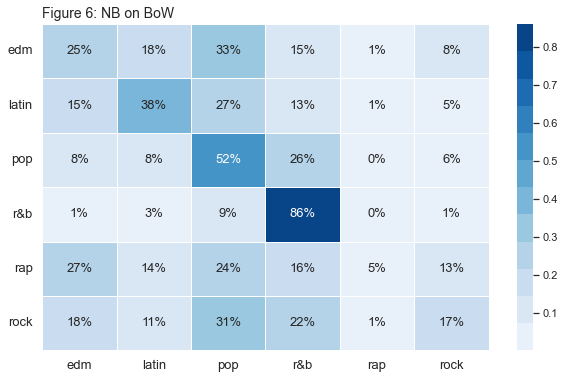

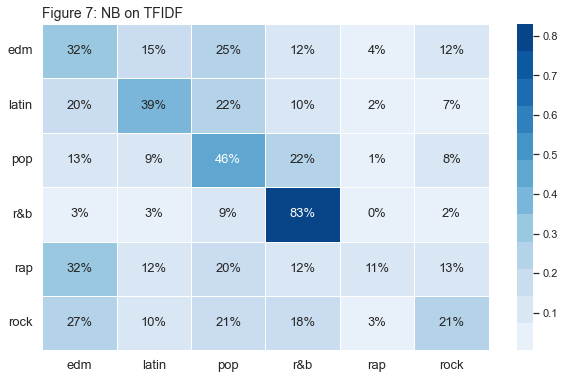

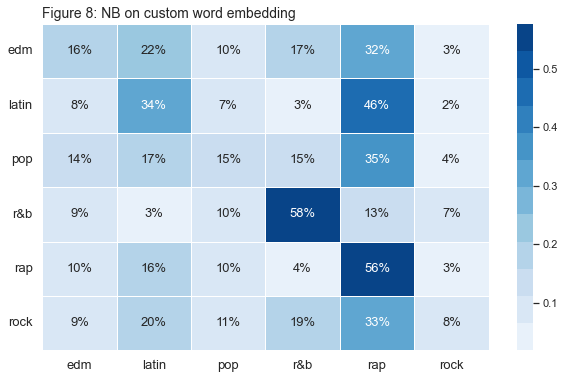

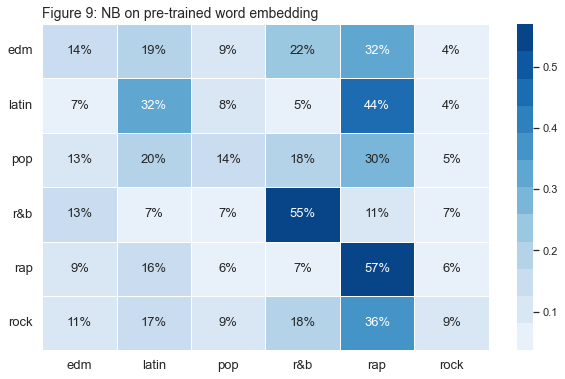

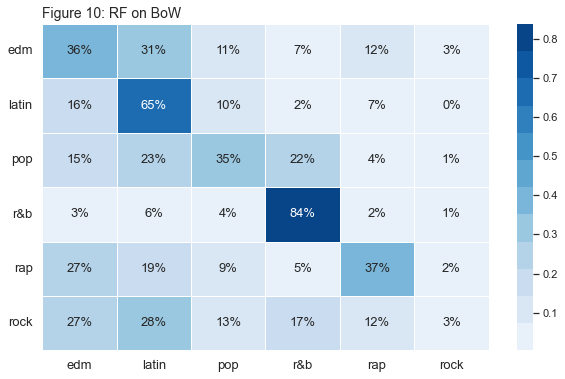

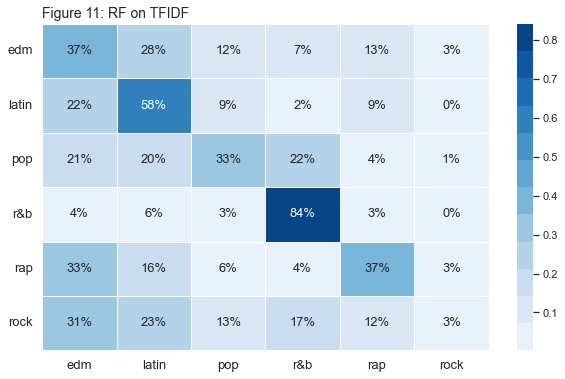

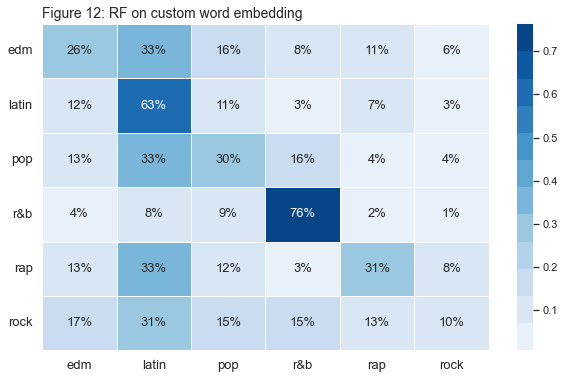

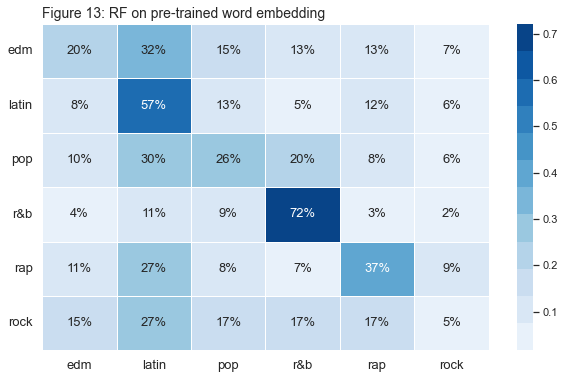

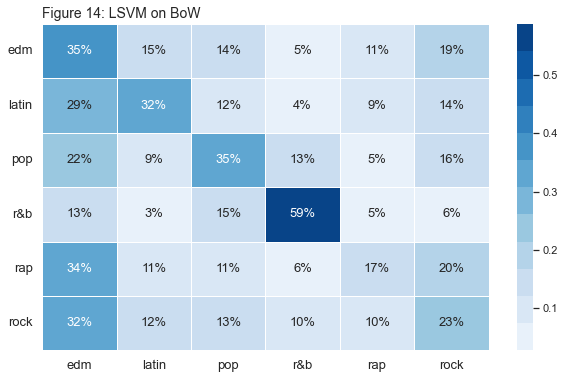

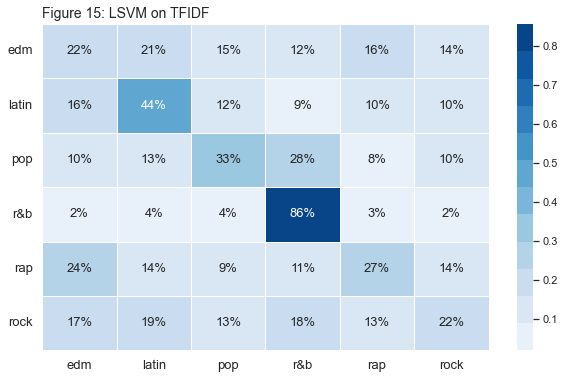

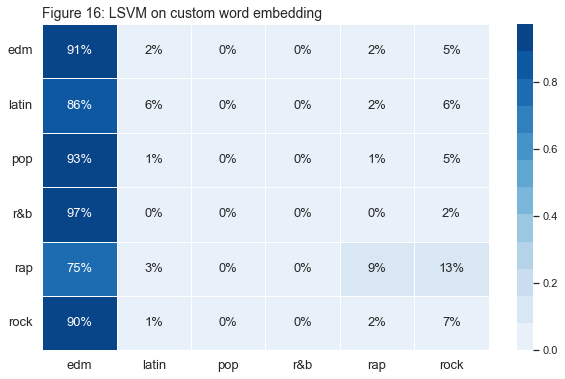

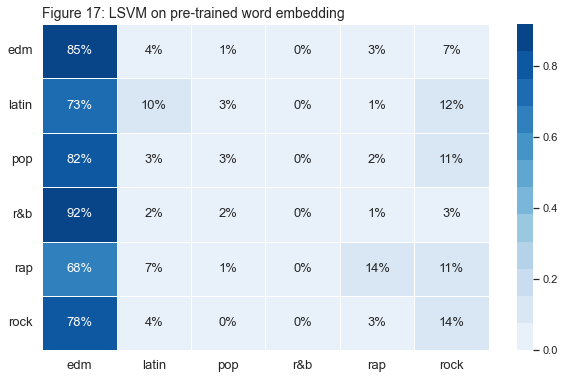

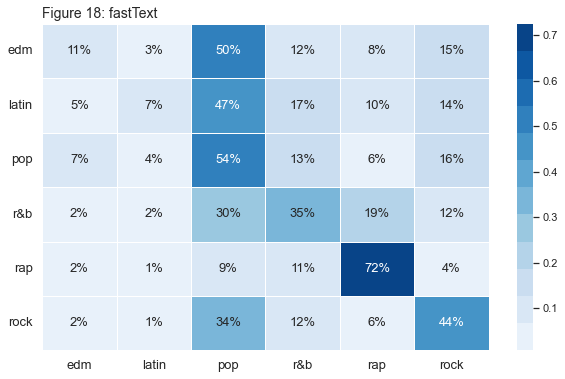

In [ ]:
conf(nb_bow_y_test,    nb_bow_pred,     6,nb_bow_title)
conf(nb_tfidf_y_test,  nb_tfidf_pred,   7,nb_tfidf_title)
conf(nb_cm_y_test,     nb_cm_pred,      8,nb_cm_title)
conf(nb_w2v_y_test,    nb_w2v_pred,     9,nb_w2v_title)

conf(rf_bow_y_test,    rf_bow_pred,     10,rf_bow_title)
conf(rf_tfidf_y_test,  rf_tfidf_pred,   11,rf_tfidf_title)
conf(rf_cm_y_test,     rf_cm_pred,      12,rf_cm_title)
conf(rf_w2v_y_test,    rf_w2v_pred,     13,rf_w2v_title)

conf(lsvm_bow_y_test,  lsvm_bow_pred,   14,lsvm_bow_title)
conf(lsvm_tfidf_y_test,lsvm_tfidf_pred, 15,lsvm_tfidf_title)
conf(lsvm_cm_y_test,   lsvm_cm_pred,    16,lsvm_cm_title)
conf(lsvm_w2v_y_test,  lsvm_w2v_pred,   17,lsvm_w2v_title)

conf(df_test_ft.act,   df_test_ft.pred1,18,'fastText')

#### c. Precision and recall by genre

In [ ]:
report(nb_bow_y_test,    nb_bow_pred,    4,nb_bow_title)
report(nb_tfidf_y_test,  nb_tfidf_pred,  5,nb_tfidf_title)
report(nb_cm_y_test,     nb_cm_pred,     6,nb_cm_title)
report(nb_w2v_y_test,    nb_w2v_pred,    7,nb_w2v_title)

report(rf_bow_y_test,    rf_bow_pred,    8,rf_bow_title)
report(rf_tfidf_y_test,  rf_tfidf_pred,  9,rf_tfidf_title)
report(rf_cm_y_test,     rf_cm_pred,     10,rf_cm_title)
report(rf_w2v_y_test,    rf_w2v_pred,    11,rf_w2v_title)

report(lsvm_bow_y_test,  lsvm_bow_pred,  12,lsvm_bow_title)
report(lsvm_tfidf_y_test,lsvm_tfidf_pred,13,lsvm_tfidf_title)
report(lsvm_cm_y_test,   lsvm_cm_pred,   14,lsvm_cm_title)
report(lsvm_w2v_y_test,  lsvm_w2v_pred,  15,lsvm_w2v_title)

report(df_test_ft.act,   df_test_ft.pred1,16,'fastText')

Table 4: NB on BoW

              precision    recall  f1-score   support

         edm       0.42      0.25      0.32       997
       latin       0.46      0.38      0.42       755
         pop       0.34      0.52      0.41       766
         r&b       0.50      0.86      0.64       670
         rap       0.50      0.05      0.09       425
        rock       0.14      0.17      0.15       230

    accuracy                           0.41      3843
   macro avg       0.39      0.37      0.34      3843
weighted avg       0.42      0.41      0.38      3843



Table 5: NB on TFIDF

              precision    recall  f1-score   support

         edm       0.40      0.32      0.35       997
       latin       0.48      0.39      0.43       755
         pop       0.37      0.46      0.41       766
         r&b       0.55      0.83      0.66       670
         rap       0.40      0.11      0.17       425
        rock       0.14      0.21      0.17       230

    accuracy                     

#### d. ROC curves (one vs the rest) for best non-fastText solution

- For each curve the genre of interest is the positive class while the other 5 genres are considered altogether as the negative classes
- This code is based on that of scikit-learn website (scikit-learn, 2022)

In [ ]:
rf=RandomForestClassifier(class_weight='balanced',min_samples_split=0.01)
rf_model_tfidf=rf.fit(X_train_tfidf_norm,         y_train.values.ravel())

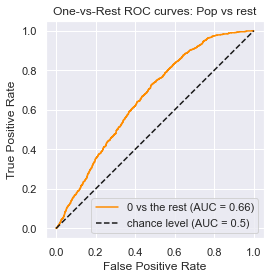

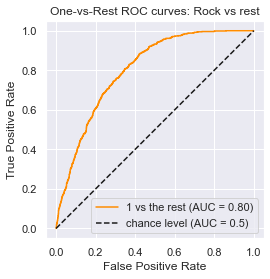

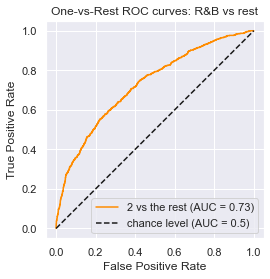

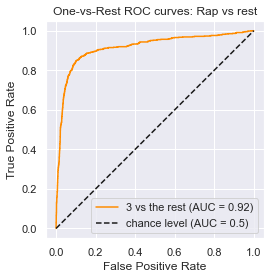

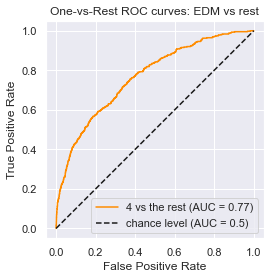

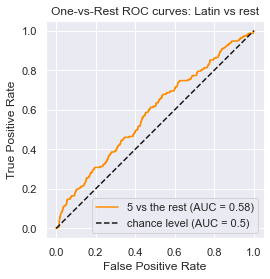

In [ ]:
# Create OHE conversion of genre
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

# Calculate genre predictions of each test song
y_score=rf_model_tfidf.predict_proba(X_test_tfidf_norm)

auc_plot(0,'Pop')
auc_plot(1,'Rock')
auc_plot(2,'R&B')
auc_plot(3,'Rap')
auc_plot(4,'EDM')
auc_plot(5,'Latin')

### <font color='blue'>2. Summary</font>

- Its disappointing that the two best performing models (TF-IDF and BoWs) in terms of performance statistics are ones which do not consider semantic meaning! However all things considered, a positive was that the fastText model which was not too far behind on these scores and could be considered the best model as it classifies the largest genres significantly better which would be necessary if implemented. fastTexts ability to deal with rare unseen words through its creation of subword n-gram maybe be the key advantage, particularly when considering much larger datasets

- Two key challenges of this project were realised during the project, namely that popular music song lyrics may not be as easily separable as that of other corpora in terms of vocabularies being relatively similar and also the need for better embedding techniques to vectorize a high degree of rare words in its vocabulary. Operationally, a key risk in coding with lots of arrays rather than dataframes is mismatching genre labels with features inputs!

- Its difficult to find comparable baselines in available in research papers due to the differences in objective (multi-label genre vs multi-class genre) and data sources (differences in datasets, genre definitions and number of genres studied). So is 47% accuracy with an f1 score 42 any good? Firstly it is important to keep in mind that this work only considers lyrics which in reality would not be the most sensible approach considering the available audio data to be used in conjunction with lyrics. Second, compared to the priors for each genre the fastText model shows considerable statistical power compared to a rule based baseline model of simply assigning all songs to the highest class - rock (prior=24%). Each of its genre's accuracy scores outperforms its representative probability (priors) except for EDM. Third, compared to the simplest model of multinomial Naive Bayes with BoWs inputs the fastTexts model outperforms it noticeably (F1 score of 0.43 versus 0.36) so statistically it has power against these two baselines. Given there are 6 genres 47% could be considered a good result but it depends on how much weight a user of the model would give a false positive or false negative.  

- Improvements on the approach undertaken could be to consider:
  - increasing the number of stop words
  - move towards n-grams being studied
  - incorporating word tagging (noun, det, adv, etc)
  - extending the context windows in CBOW/Skip-Gram methodologies in word embeddings; and
  - if feeling brave building an embedding from scratch using LSTM deep learning incorporating sequences
  - Also, the re-balancing did not seem to provide an increase in performance so further investigation here is required
  
From reading relevant papers the basic approach employed seems to be transferable so other users could easily adopt it enhance it and vice versa especially if another approach considers only audio data features and wants to incoporate lyrics as a feature

## <font color='brown'>IV. References</font>

1. Boonyanit, A. and Dahl, A., _Music Genre Classification using Song Lyrics_, 2021, found at: https://web.stanford.edu/class/cs224n/reports/final_reports/report003.pdf
2. Valeti, D., _Classification using Word2vec_, 2021, found at: https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381
3. scikit-learn, _Multiclass Receiver Operating Characteristic (ROC)_, 2022, found at https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## <font color='brown'>V. Requirements file</font>

In [ ]:
pip freeze >> requirements.txt

Note: you may need to restart the kernel to use updated packages.
